In [2]:
import numpy as np
import time
import CalculateAnomalies as ca
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Activation
from keras.layers import Dropout

# import data
import SimAnomalyDataset as sim
data, anomaly_loc, anomaly_dur,dates = sim.get_data(n='Y')

seq_len = 100
sequence_length = seq_len + 1
result = []
for index in range(len(data) - sequence_length):
    result.append(data[index: index + sequence_length])

result = np.array(result)

row = round(0.8 * result.shape[0])
train = result[:int(row), :]
np.random.shuffle(train)
x_train = train[:, :-1]
y_train = train[:, -1]
x_test = result[int(row):, :-1]
y_test = result[int(row):, -1]

X_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
X_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  

def build_model(layers):
    model = Sequential()

    model.add(LSTM(input_dim=layers[0],output_dim=layers[1],return_sequences=True))
    
    model.add(Dropout(0.2))

    model.add(LSTM(layers[2],return_sequences=False))
    
    model.add(Dropout(0.2))

    model.add(Dense(output_dim=layers[3]))
    
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop")
    print("> Compilation Time : ", time.time() - start)
    return model

def predict_point_by_point(model, data):
    #Predict each timestep given the last sequence of true data, in effect only predicting 1 step ahead each time
    predicted = model.predict(data)
    predicted = np.reshape(predicted, (predicted.size,))
    return predicted

epochs  = 4
seq_len = 200

print('> Data Loaded. Compiling...')

model = build_model([1, 50, 100, 1])

model.fit(
    X_train,
    y_train,
    batch_size=512,
    nb_epoch=epochs,
    validation_split=0.05)

predicted = predict_point_by_point(model, X_test)

> Data Loaded. Compiling...


/home/codepan1/.local/lib/python3.5/site-packages/ipykernel_launcher.py:37: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
/home/codepan1/.local/lib/python3.5/site-packages/ipykernel_launcher.py:37: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(input_shape=(None, 1), units=50, return_sequences=True)`
/home/codepan1/.local/lib/python3.5/site-packages/ipykernel_launcher.py:45: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`
/home/codepan1/.local/lib/python3.5/site-packages/keras/models.py:848: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


> Compilation Time :  0.00928807258605957
Train on 7523 samples, validate on 396 samples
Epoch 1/4
7523/7523 [==============================] - 13s - loss: 303.3891 - val_loss: 279.4544
Epoch 2/4
7523/7523 [==============================] - 13s - loss: 286.4676 - val_loss: 260.4044
Epoch 3/4
7523/7523 [==============================] - 14s - loss: 265.8791 - val_loss: 240.3127
Epoch 4/4
7523/7523 [==============================] - 14s - loss: 254.1131 - val_loss: 259.7255


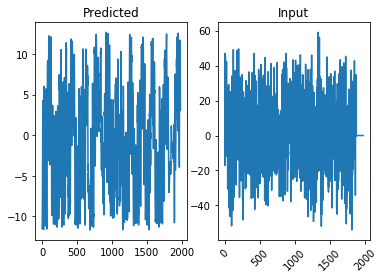

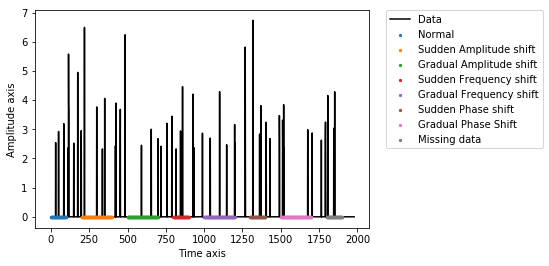

In [9]:
from evaluatePredictions import main

# Compare input to predicted visually
plt.figure(1)
plt.subplot(1,2,1)
plt.plot(predicted)
plt.title('Predicted')
plt.subplot(1,2,2)
plt.plot(x_test[:,0])
plt.title('Input')
plt.xticks(rotation=45)
plt.show()


# Compute comparison metric for predicted vs input (anomalies)
out = main(x_test[:,0], predicted, metric="MPE")

# Threshold metric before plotting
thresh = 10
to_plot = out
to_plot=np.asarray(to_plot)
to_plot[to_plot<thresh]=1

sim.plot_data(np.log(to_plot), anomaly_loc, anomaly_dur)